In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats

from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d


/tmp/ipykernel_166848/881955431.py:7: DeprecationWarning: Please import `gaussian_filter1d` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
# main_dir = "/media/baetes01/baetelabspace/on_sampling/smi"
main_dir = "/media/baetes01/baetelabspace/on_sampling/smi_fw"

# register_type = "register"
# rois_prefix = "t1_"

# register_type = "register_atlas"
# rois_prefix = "b0_"

register_type = "register_atlas"
rois_prefix = "b0_proj_"

plots_dir = "plots"

all_subject_dirs = [
    "sub-01800777", "sub-13949233", "sub-14575264", "sub-15210884", 
    "sub-15880428", "sub-16125652", "sub-16331017", "sub-16589788"
]

# subject_dirs = [
#     all_subject_dirs[0],
#     all_subject_dirs[1],
#     all_subject_dirs[2],
#     all_subject_dirs[3],
#     all_subject_dirs[6],
#     all_subject_dirs[7],
# ]

subject_dirs = all_subject_dirs

subjects_num = len(subject_dirs)

tract_samples_num = 12

intraorbital_segment_end = 5
intracanalicular_segment_end = 8

micro_params_lower_bound = 0
micro_params_upper_bound = 10

if not os.path.isdir(plots_dir):
    os.mkdir(plots_dir)


In [3]:
def get_micro_param_samples(micro_param, session):

    micro_params_l = np.zeros((subjects_num, tract_samples_num))
    micro_params_r = np.zeros_like(micro_params_l)

    for subject_id in range(subjects_num):

        try:
        
            csv_dir = "%s/%s/ses-%s/%s" % (main_dir, subject_dirs[subject_id], session, register_type)
    
            csv_file = "%s/stat_%s%s.csv" % (csv_dir, rois_prefix, micro_param)
            data_pd = pd.read_csv(csv_file, sep='\t')
            micro_params = data_pd.to_numpy()
    
            csv_dilm_file = "%s/stat_%s%s_dilm.csv" % (csv_dir, rois_prefix, micro_param)
            data_dilm_pd = pd.read_csv(csv_dilm_file, sep='\t')
            micro_params_dilm = data_dilm_pd.to_numpy()
            
            # micro_params = (1/8) * micro_params + (7/8) * micro_params_dilm
    #         micro_params = micro_params_dilm

            if micro_param in ["D_a", "D_e", "D_r", "D_iso"]:
                micro_params = micro_params * 1.0 # 1e9
            elif micro_param in ["md", "ad", "rd"]:
                micro_params = micro_params * 1.0 # 1e3
            elif micro_param == "diam":
                micro_params = micro_params * 1e6

            micro_params = np.maximum(micro_params_lower_bound, micro_params)
            micro_params = np.minimum(micro_params_upper_bound, micro_params)
            
            micro_params_l[subject_id] = micro_params[:,0]
            micro_params_r[subject_id] = micro_params[:,1]

        except:
            print("Missing data from subject %s." % subject_dirs[subject_id])
            # micro_params_l[subject_id] = np.NaN
            # micro_params_r[subject_id] = np.NaN
        
    return micro_params_l.T, micro_params_r.T

In [4]:
def plot_micro_params(micro_params, y_label=""):
    
    for i in range(micro_params.shape[1]):
        ysmoothed = gaussian_filter1d(micro_params[:,i], sigma=1)
        plt.plot(ysmoothed)

    plt.plot((tract_samples_num-1) * np.array([1,1]), [-100,100], 'k:')
    plt.xticks(
        (tract_samples_num-1) * np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]), 
        ['0%\n(anterior end)', '20%', '40%', '60%', '80%', '100%\n(posterior end)']
    )
    plt.xlim(0, (tract_samples_num-1) * 1.35)
    
    if y_label:
        plt.ylabel(y_label)
    
    

In [5]:
def plot_aggregated_micro_params(micro_params, color, bar_id, y_label=""):

    smoothed_micro_params = np.zeros_like(micro_params)
    
    for i in range(micro_params.shape[1]):
        smoothed_micro_params[:,i] = gaussian_filter1d(micro_params[:,i], sigma=1)
    
    micro_params_avg = np.nanmean(smoothed_micro_params, axis=1)
    micro_params_std = np.nanstd(smoothed_micro_params, axis=1)
    
    y = np.hstack((micro_params_avg+micro_params_std, np.flip(micro_params_avg-micro_params_std)))
    x = np.hstack((range(tract_samples_num), np.flip(range(tract_samples_num))))

    plt.fill(x, y, c=color, alpha=0.1)
    plt.plot(micro_params_avg.T, linewidth=2, color=color)
    
#     micro_params_total_avg = np.nanmean(micro_params)
#     micro_params_total_std = np.nanstd(micro_params)

    
    micro_params_subject_avg = np.nanmean(micro_params, axis=0)

    micro_params_total_avg = np.mean(micro_params_subject_avg)
    micro_params_total_std = np.std(micro_params_subject_avg)
    
    plt.bar(
        x=1.10*(tract_samples_num-1)+0.15*(tract_samples_num-1)*bar_id, 
        width=0.1*(tract_samples_num-1), height=micro_params_total_avg, yerr=micro_params_total_std, color=color
    )
    plt.text(
        1.09*(tract_samples_num-1)+0.17*(tract_samples_num-1)*bar_id, micro_params_total_avg+micro_params_total_std, 
        "%.2f±%.2f\n" % (micro_params_total_avg, micro_params_total_std),
        horizontalalignment='center', fontsize=9
    )

    plt.plot((tract_samples_num-1) * np.array([1,1]), [-100,100], 'k:')
    plt.plot(intraorbital_segment_end * np.array([1,1]), [-100,100], 'k:')
    plt.plot((intracanalicular_segment_end) * np.array([1,1]), [-100,100], 'k:')
    
    plt.xticks(
        (tract_samples_num-1) * np.array([0.0, 0.2, 0.4, 0.6, 0.8, 1.0]), 
        ['0%\n(anterior end)', '20%', '40%', '60%', '80%', '100%\n(posterior end)']
    )
    plt.xlim(0, (tract_samples_num-1) * 1.35)
    
    if y_label:
        plt.ylabel(y_label)
    
    return micro_params_subject_avg
   

In [6]:
def draw_figure(micro_param_name, micro_param_label, y_lim):

#     try:
 
        micro_l_test, micro_r_test = get_micro_param_samples(micro_param_name, 'test')
        micro_l_retest, micro_r_retest = get_micro_param_samples(micro_param_name, 'retest')

#         # ON left (test)
    
#         plt.figure(figsize=(8,3))

#         plot_micro_params(micro_l_test, micro_param_label)
#         plt.ylim(y_lim)
#         # plt.legend(subject_dirs)
       
#         plt.title("ON left (test)")
                
# #         plt.savefig("%s/%s%s_l_test.pdf" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')
#         plt.savefig("%s/%s%s_l_test.png" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')

# #         # ON left (retest)

#         plt.figure(figsize=(8,3))

#         plot_micro_params(micro_l_retest, micro_param_label)
#         plt.ylim(y_lim)
#         # plt.legend(subject_dirs)
       
#         plt.title("ON left (retest)")
                
# #         plt.savefig("%s/%s%s_l_retest.pdf" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')
#         plt.savefig("%s/%s%s_l_retest.png" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')

#         # ON right (test)
    
#         plt.figure(figsize=(8,3))

#         plot_micro_params(micro_r_test, micro_param_label)
#         plt.ylim(y_lim)
#         # plt.legend(subject_dirs)

#         plt.title("ON right (test)")

# #         plt.savefig("%s/%s%s_r_test.pdf" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')
#         plt.savefig("%s/%s%s_r_test.png" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')
        
#         # ON right (retest)
    
#         plt.figure(figsize=(8,3))

#         plot_micro_params(micro_r_retest, micro_param_label)
#         plt.ylim(y_lim)
#         # plt.legend(subject_dirs)

#         plt.title("ON right (retest)")

# #         plt.savefig("%s/%s%s_r_retest.pdf" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')
#         plt.savefig("%s/%s%s_r_retest.png" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')
        

        # Aggregated plots (left)

        plt.figure(figsize=(8,3))
        
        plt.plot([-1,-1], [0,1], c='C0')
        plt.plot([-1,-1], [0,1], c='C1')

        micro_params_subject_avg_r = plot_aggregated_micro_params(micro_l_test, 'C0', 0, "")
        micro_params_subject_avg_l = plot_aggregated_micro_params(micro_l_retest, 'C1', 1, micro_param_label)
        plt.ylim(y_lim)

        plt.title("%s (OS)" % micro_param_label, fontweight='bold')
        plt.legend(['test', 'retest'], loc='upper left')
        # plt.savefig("%s/%s_%s_aggregated_os.pdf" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')
        plt.savefig("%s/%s%s_aggregated_os.png" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')
        
        # Aggregated plots (right)

        plt.figure(figsize=(8,3))
        
        plt.plot([-1,-1], [0,1], c='C0')
        plt.plot([-1,-1], [0,1], c='C1')

        micro_params_subject_avg_r = plot_aggregated_micro_params(micro_r_test, 'C0', 0, "")
        micro_params_subject_avg_l = plot_aggregated_micro_params(micro_r_retest, 'C1', 1, micro_param_label)
        plt.ylim(y_lim)

        plt.title("%s (OD)" % micro_param_label, fontweight='bold')
        plt.legend(['test', 'retest'], loc='upper left')
        # plt.savefig("%s/%s_%s_aggregated_od.pdf" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')
        plt.savefig("%s/%s%s_aggregated_od.png" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')

        # # Aggregated plots (test-retest)

        # plt.figure(figsize=(8,3))
        
        # plt.plot([-1,-1], [0,1], c='C0')
        # plt.plot([-1,-1], [0,1], c='C1')

        # micro_params_subject_avg_r = plot_aggregated_micro_params(np.abs(micro_l_test-micro_l_retest), 'C0', 0, "")
        # micro_params_subject_avg_l = plot_aggregated_micro_params(np.abs(micro_r_test-micro_r_retest), 'C1', 1, micro_param_label)
        # plt.ylim(y_lim)

        # plt.title("%s (test-retest)" % micro_param_label, fontweight='bold')
        # plt.legend(['OS', 'OD'], loc='upper left')
        # # plt.savefig("%s/%s_%s_aggregated_diff.pdf" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')
        # plt.savefig("%s/%s%s_aggregated_test-retest.png" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')

        # # Aggregated plots (OS-OD)

        # plt.figure(figsize=(8,3))
        
        # plt.plot([-1,-1], [0,1], c='C0')
        # plt.plot([-1,-1], [0,1], c='C1')

        # micro_params_subject_avg_r = plot_aggregated_micro_params(np.abs(micro_l_test-micro_r_test), 'C0', 0, "")
        # micro_params_subject_avg_l = plot_aggregated_micro_params(np.abs(micro_l_retest-micro_r_retest), 'C1', 1, micro_param_label)
        # plt.ylim(y_lim)

        # plt.title("%s (OS-OD)" % micro_param_label, fontweight='bold')
        # plt.legend(['test', 'retest'], loc='upper left')
        # # plt.savefig("%s/%s_%s_aggregated_diff.pdf" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')
        # plt.savefig("%s/%s%s_aggregated_os-od.png" % (plots_dir, rois_prefix, micro_param_name), bbox_inches='tight')

        segment_labels = {
            0: "Intraorbital segment",
            1: "Intracanalicular segment",
            2: "Intracranial segment"
        }

#     except Exception as e:
#         print(e)


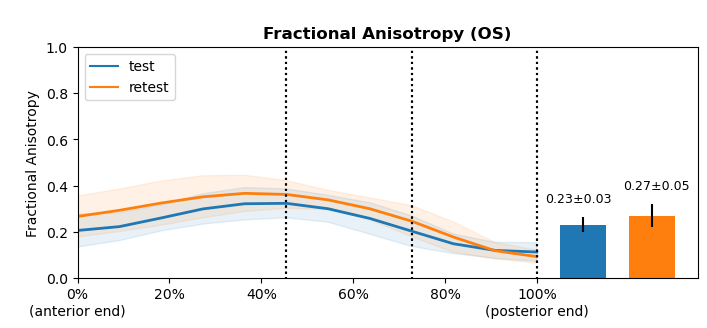

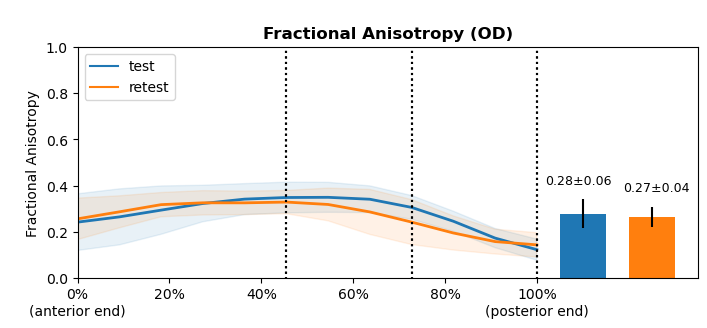

In [7]:
draw_figure("fa", "\nFractional Anisotropy", [0.0,1.0])

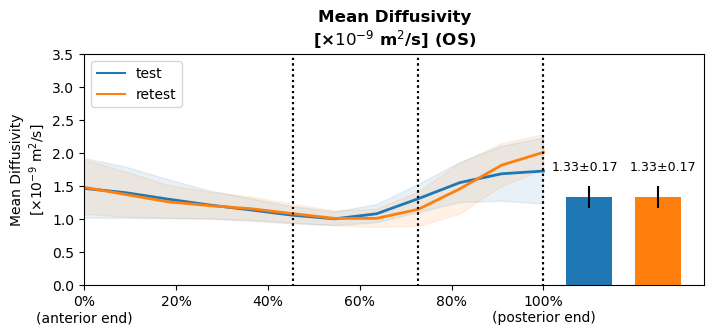

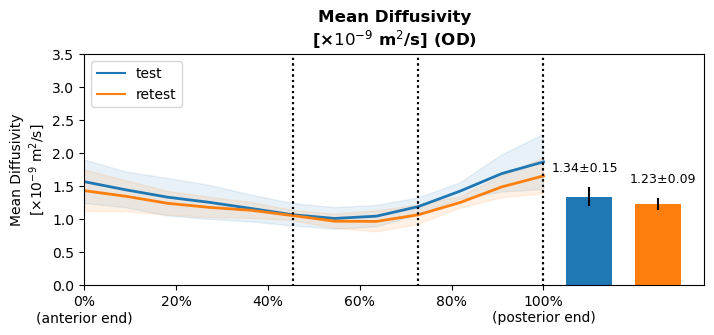

In [8]:
draw_figure("md", "Mean Diffusivity\n[×$10^{-9}$ m$^2$/s]", [0.0,3.5])

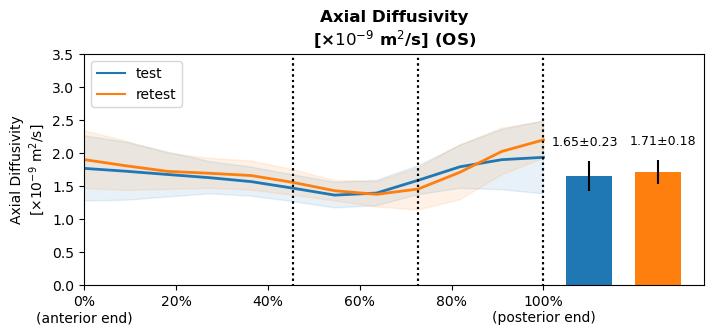

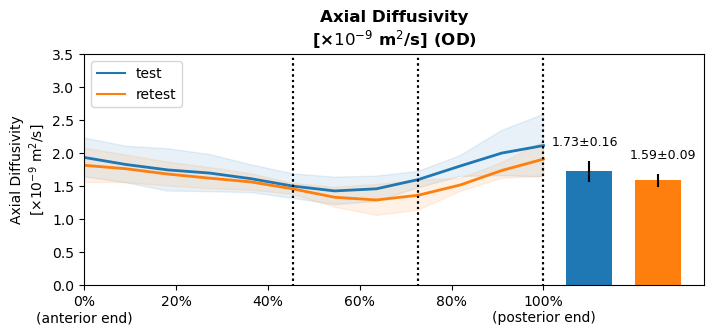

In [9]:
draw_figure("ad", "Axial Diffusivity\n[×$10^{-9}$ m$^2$/s]", [0.0,3.5])

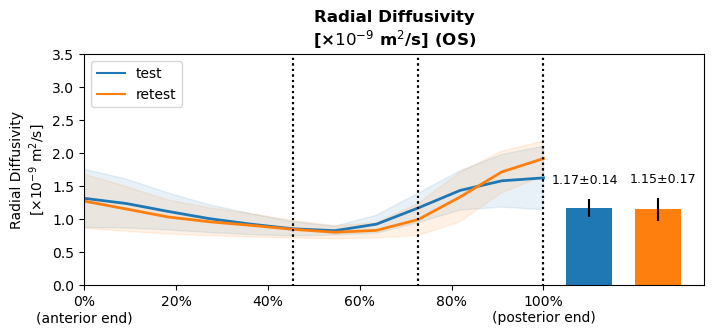

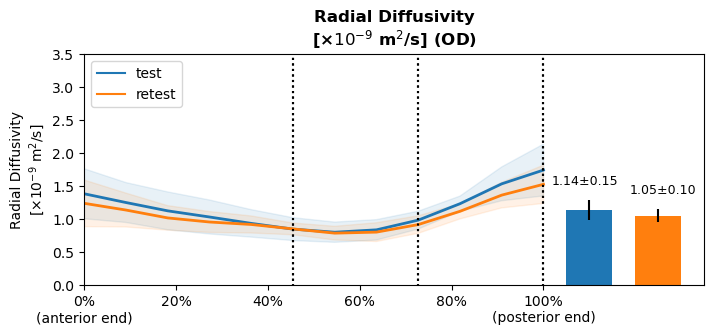

In [10]:
draw_figure("rd", "Radial Diffusivity\n[×$10^{-9}$ m$^2$/s]", [0.0,3.5])

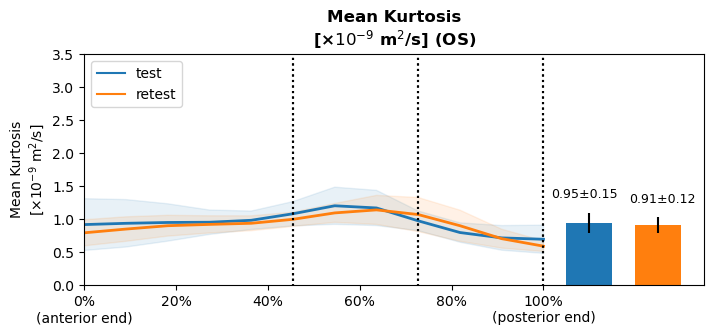

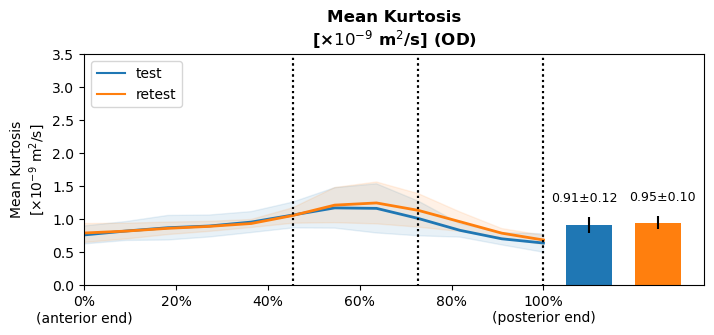

In [11]:
draw_figure("mk", "Mean Kurtosis\n[×$10^{-9}$ m$^2$/s]", [0.0,3.5])

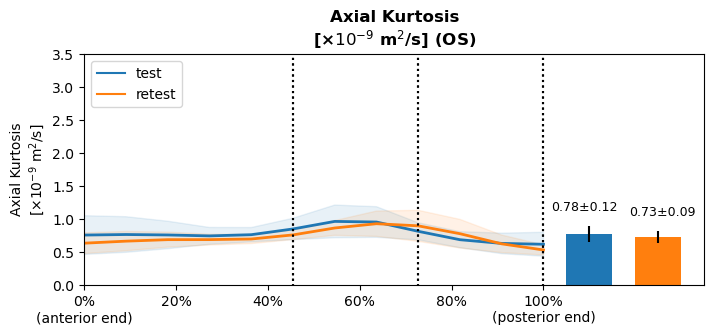

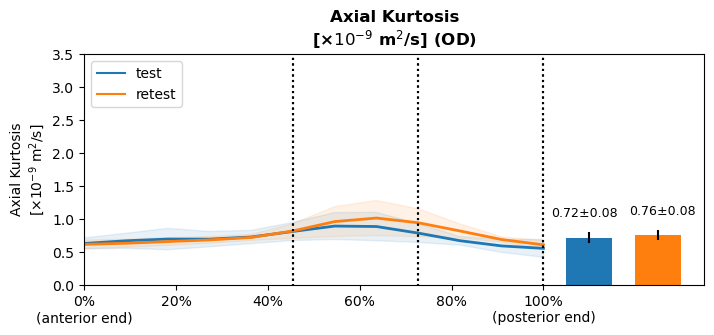

In [12]:
draw_figure("ak", "Axial Kurtosis\n[×$10^{-9}$ m$^2$/s]", [0.0,3.5])

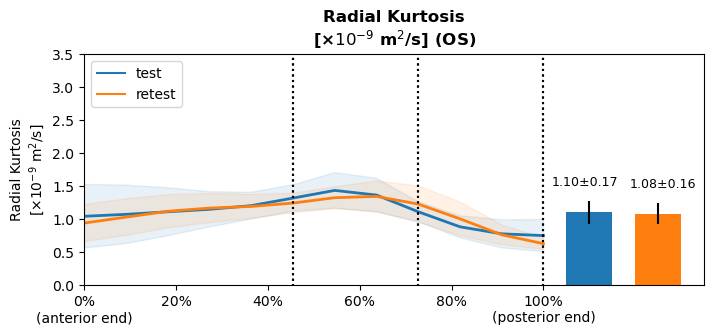

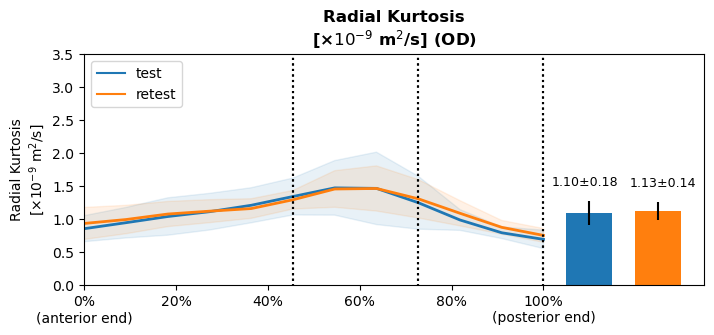

In [13]:
draw_figure("rk", "Radial Kurtosis\n[×$10^{-9}$ m$^2$/s]", [0.0,3.5])

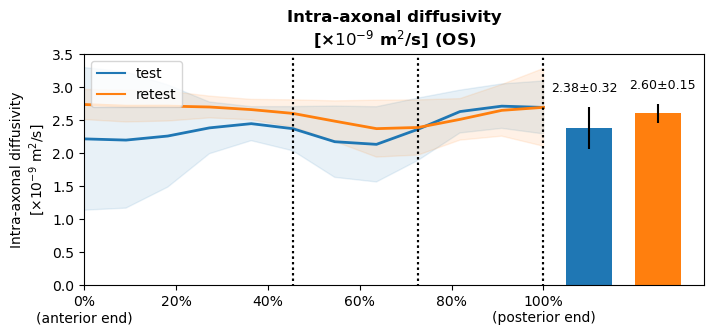

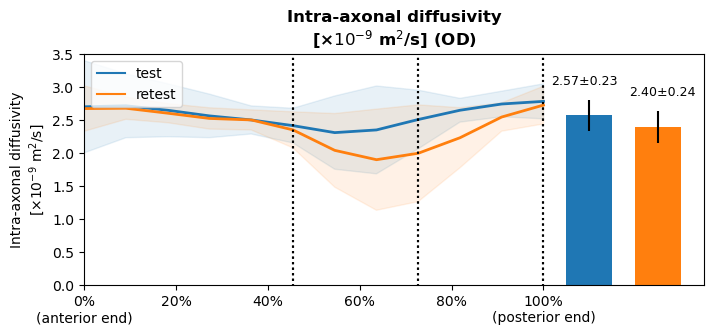

In [14]:
draw_figure("Da", "Intra-axonal diffusivity\n[×$10^{-9}$ m$^2$/s]", [0.0,3.5])

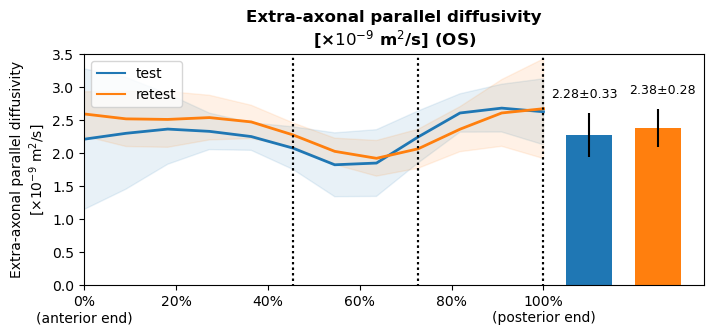

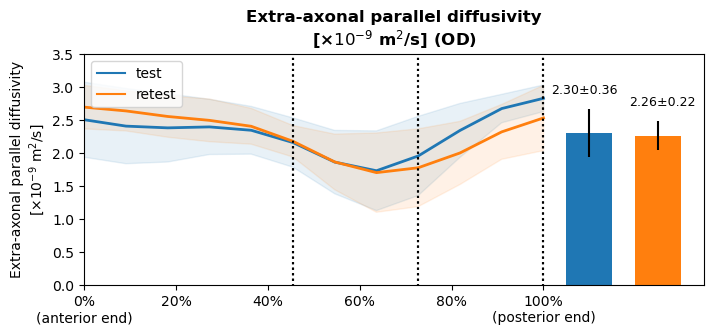

In [15]:
draw_figure("DePar", "Extra-axonal parallel diffusivity\n[×$10^{-9}$ m$^2$/s]", [0.0,3.5])

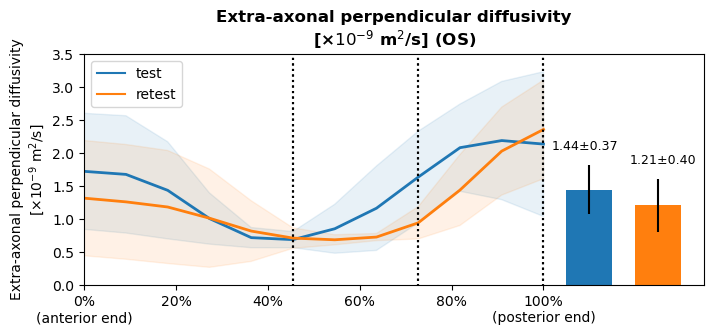

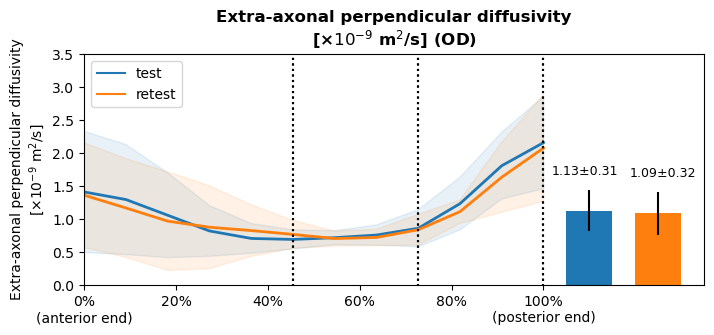

In [16]:
draw_figure("DePerp", "Extra-axonal perpendicular diffusivity\n[×$10^{-9}$ m$^2$/s]", [0.0,3.5])

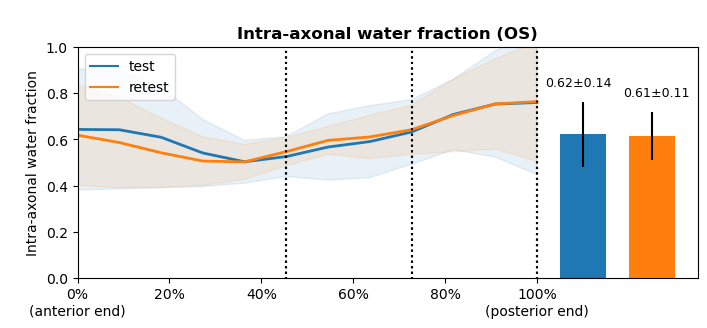

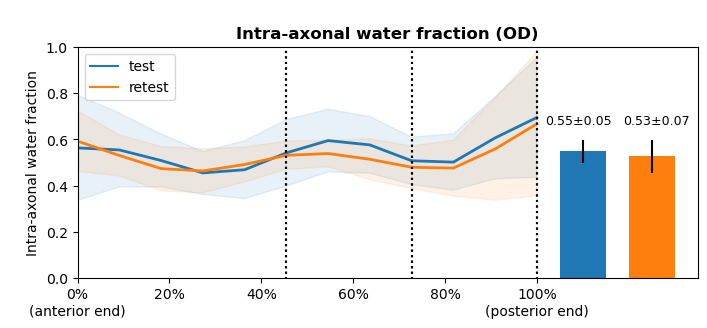

In [17]:
draw_figure("f", "\nIntra-axonal water fraction", [0.0,1.0])

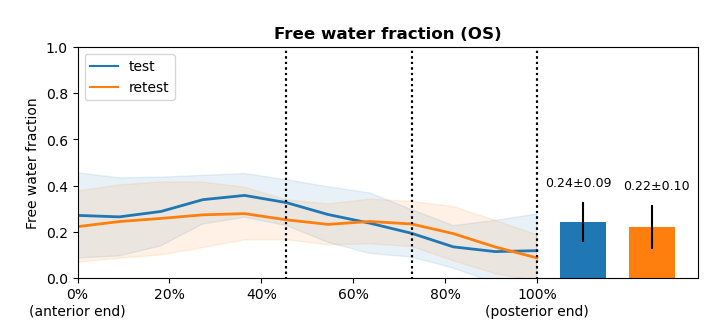

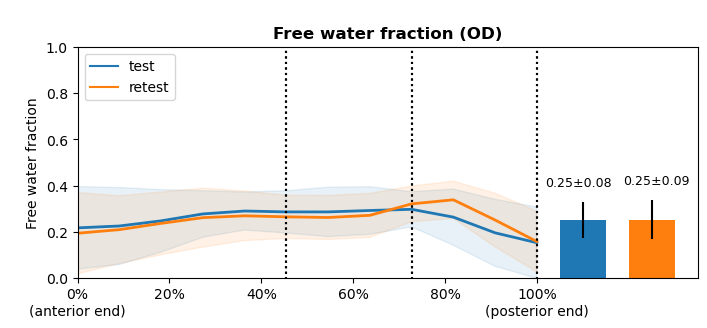

In [18]:
draw_figure("fw", "\nFree water fraction", [0.0,1.0])

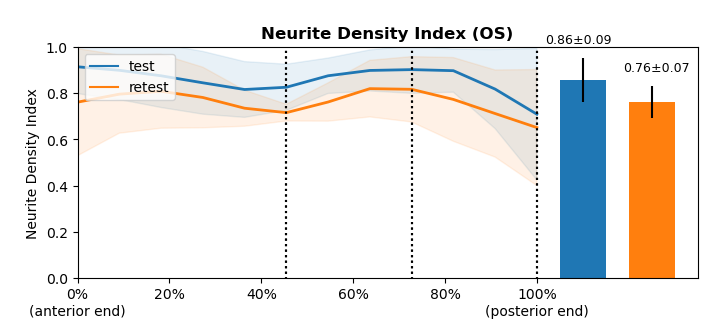

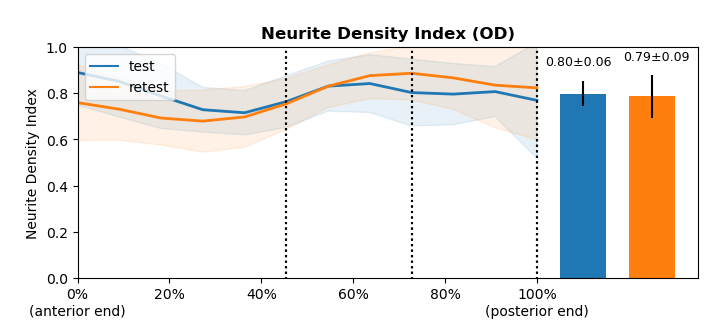

In [19]:
draw_figure("noddi_ndi", "\nNeurite Density Index", [0.0,1.0])

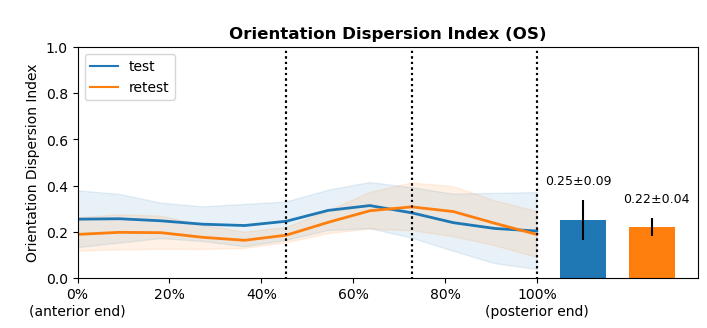

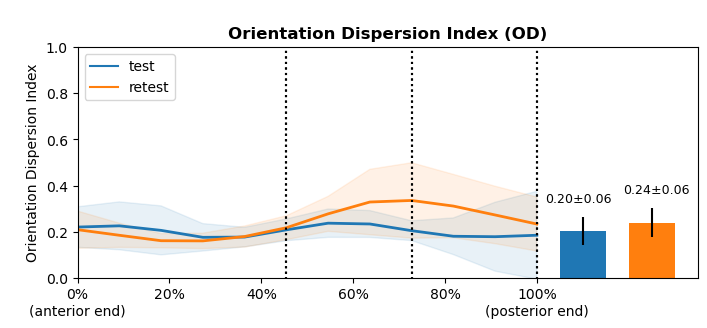

In [20]:
draw_figure("noddi_odi", "\nOrientation Dispersion Index", [0.0,1.0])

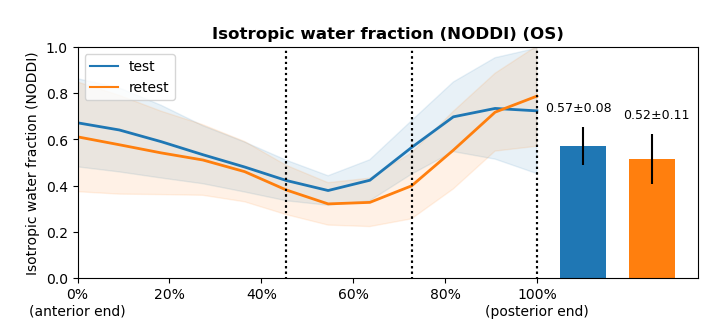

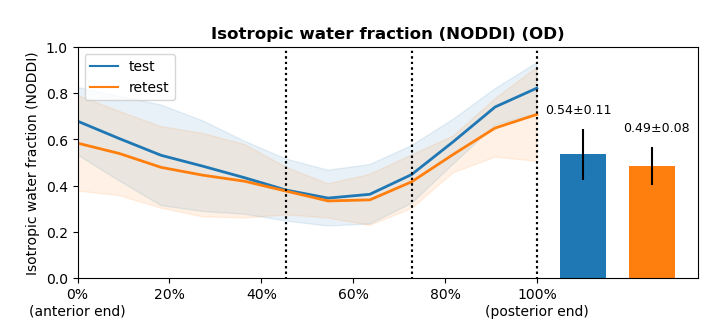

In [21]:
draw_figure("noddi_p_iso", "\nIsotropic water fraction (NODDI)", [0.0,1.0])

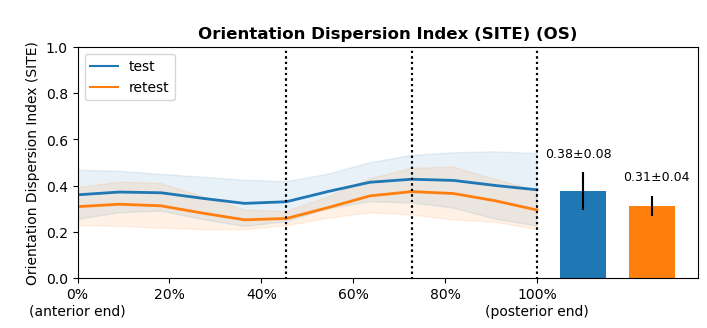

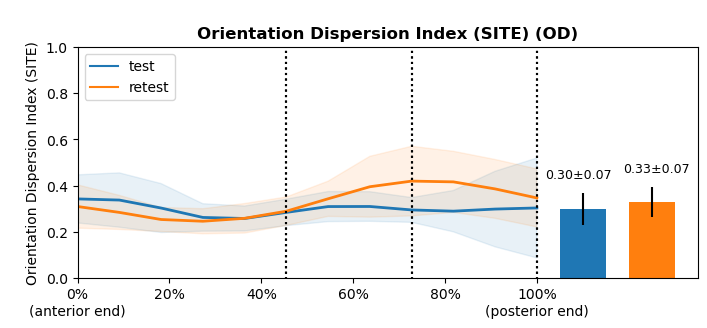

In [22]:
draw_figure("site_noddi_odi", "\nOrientation Dispersion Index (SITE)", [0.0,1.0])

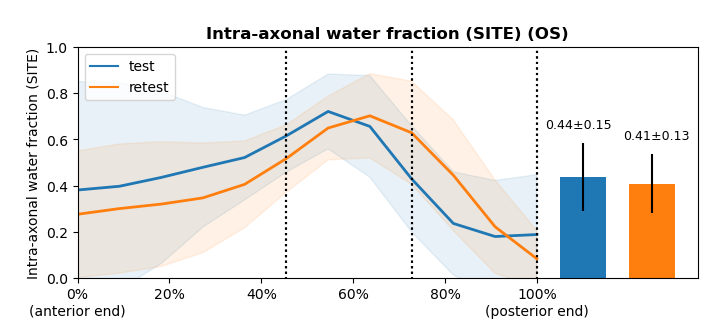

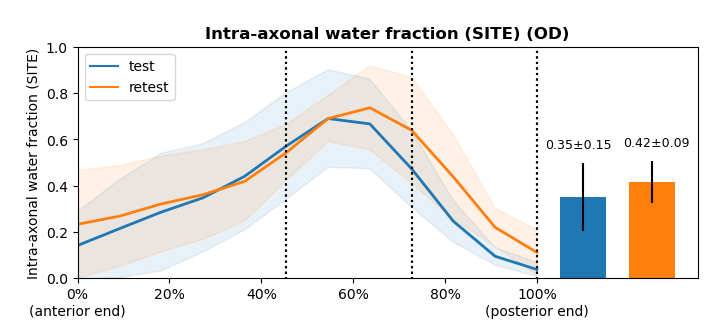

In [23]:
draw_figure("site_noddi_p_1", "\nIntra-axonal water fraction (SITE)", [0.0,1.0])

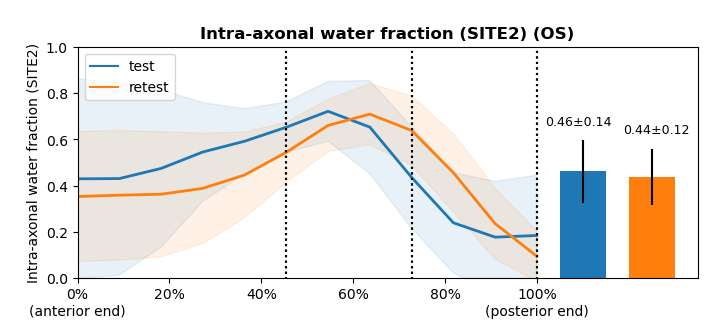

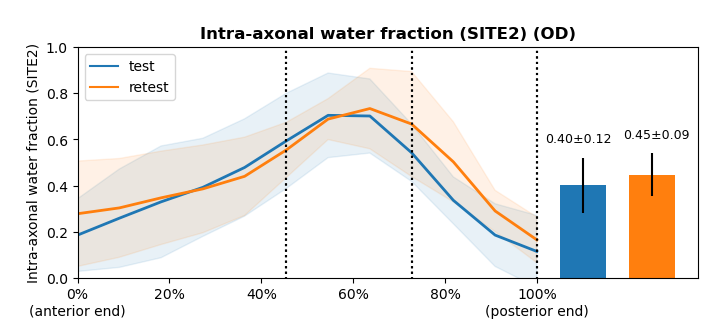

In [24]:
draw_figure("site2_smt_p_1", "\nIntra-axonal water fraction (SITE2)", [0.0,1.0])

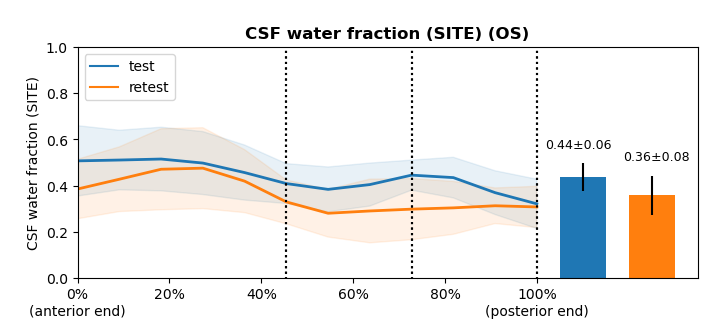

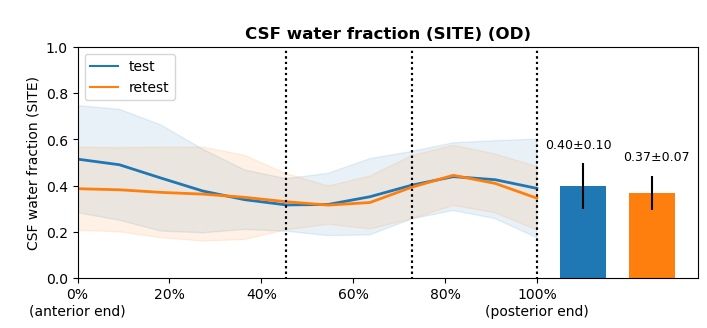

In [25]:
draw_figure("site_noddi_p_csf", "\nCSF water fraction (SITE)", [0.0,1.0])

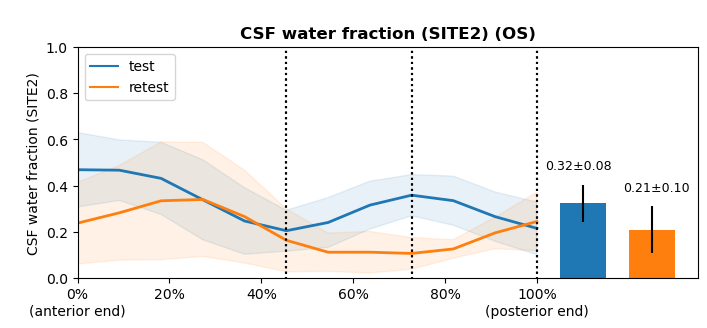

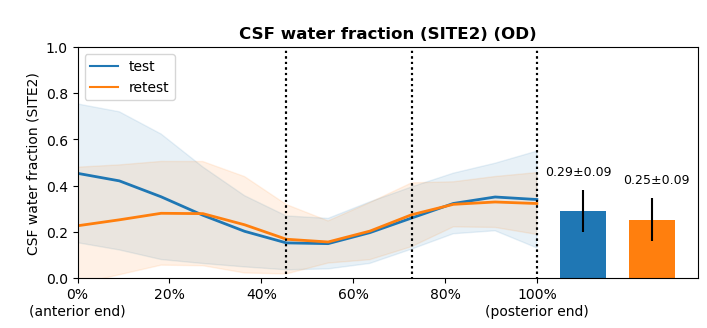

In [26]:
draw_figure("site2_smt_p_csf", "\nCSF water fraction (SITE2)", [0.0,1.0])

In [27]:
micro_param_names = [
    'fa', 'md', 'ad', 'rd', 
    'mk', 'ak', 'rk',
    'f', 'Da', 'DePar', 'DePerp', # 'fw', 
    # 'noddi_ndi', 'noddi_odi', 'noddi_p_iso',
    # 'site_noddi_odi', 'site_noddi_p_1', 'site_noddi_p_csf',
    # 'site2_smt_p_1', 'site2_smt_p_csf', 'site2_smt_p_iso'
]

micro_param_labels = {
    'fa': 'FA', 'md': 'MD', 'ad': 'AD', 'rd': 'RD', 
    'mk': 'MK', 'ak': 'AK', 'rk': 'RK',
    'f': 'f', 'fw': 'f$_{iso}$', 'Da': 'D$_a$', 'DePar': 'D$_{e||}$', 'DePerp': 'D$_{e⊥}$',
    'noddi_ndi': 'NDI', 'noddi_odi': 'ODI', 'noddi_p_iso': 'p$_{iso}$',
    'site_noddi_odi': 'ODI', 'site_noddi_p_1': 'p$_1$', 'site_noddi_p_csf': 'p$_{CSF}$',
    'site2_smt_p_1': 'p$_1$', 'site2_smt_p_2': 'p$_2$', 'site2_smt_p_csf': 'p$_{CSF}$', 'site2_smt_p_iso': 'p$_{iso}$'
}

values_reg = {} 
values_reg_proj = {}

for micro_param_name in micro_param_names:

    # reg
    register_type = "register_atlas"
    rois_prefix = "b0_"
    
    micro = {}
    micro['micro_l_test'], micro['micro_r_test'] = get_micro_param_samples(micro_param_name, 'test')
    micro['micro_l_retest'], micro['micro_r_retest'] = get_micro_param_samples(micro_param_name, 'retest')

    values_reg[micro_param_name] = micro

    # reg+proj
    register_type = "register_atlas"
    rois_prefix = "b0_proj_"

    micro = {}
    micro['micro_l_test'], micro['micro_r_test'] = get_micro_param_samples(micro_param_name, 'test')
    micro['micro_l_retest'], micro['micro_r_retest'] = get_micro_param_samples(micro_param_name, 'retest')

    values_reg_proj[micro_param_name] = micro




In [156]:
DIFF_REG_AVG = 0
DIFF_REG_STD = 1
DIFF_REG_PROJ_AVG = 2
DIFF_REG_PROJ_STD = 3

DIFF_LEFT_RIGHT_TEST = 0
DIFF_LEFT_RIGHT_RETEST = 1
DIFF_TEST_RETEST_LEFT = 2
DIFF_TEST_RETEST_RIGHT = 3

errors = np.zeros([len(micro_param_names), 4, 4])

COV_REG = 0
COV_REG_PROJ = 1

COV_REG_AVG = 0
COV_REG_STD = 1
COV_REG_PROJ_AVG = 2
COV_REG_PROJ_STD = 3

COV_LEFT_TEST = 0
COV_LEFT_RETEST = 1
COV_RIGHT_TEST = 2
COV_RIGHT_RETEST = 3

SEGMENT_INTRAORBITAL = 0
SEGMENT_INTRACANALICULAR = 1
SEGMENT_INTRACRANIAL = 2

CURRENT_SEGMENT = SEGMENT_INTRACRANIAL # SEGMENT_INTRACRANIAL # SEGMENT_INTRACANALICULAR # SEGMENT_INTRAORBITAL

cov_tests = {
    COV_LEFT_TEST: 'micro_l_test', COV_LEFT_RETEST: 'micro_l_retest', 
    COV_RIGHT_TEST: 'micro_r_test', COV_RIGHT_RETEST: 'micro_r_retest'
}

covs = np.zeros([len(micro_param_names), 4, 4])
merged_covs = np.zeros([len(micro_param_names), 4, 2])

def get_aggregated_erros(idx, test1, test2):
    
    diff_reg = np.abs(
        values_reg[micro_param_names[idx]][test1] - values_reg[micro_param_names[idx]][test2]
    )
    diff_reg_proj = np.abs(
        values_reg_proj[micro_param_names[idx]][test1] - values_reg_proj[micro_param_names[idx]][test2]
    )

    return [
        np.nanmean(diff_reg), np.nanstd(diff_reg),
        np.nanmean(diff_reg_proj), np.nanstd(diff_reg_proj)
    ]


def get_coefficient_of_variation(idx, test):

    reg_avg = np.nanmean(values_reg[micro_param_names[idx]][test], axis=0)
    reg_std = np.nanstd(values_reg[micro_param_names[idx]][test], axis=0)

    reg_proj_avg = np.nanmean(values_reg_proj[micro_param_names[idx]][test], axis=0)
    reg_proj_std = np.nanstd(values_reg_proj[micro_param_names[idx]][test], axis=0)
    
    cov_reg = reg_std / reg_avg
    cov_reg_proj = reg_proj_std / reg_proj_avg
    
    return [
        np.nanmean(cov_reg), np.nanstd(cov_reg),
        np.nanmean(cov_reg_proj), np.nanstd(cov_reg_proj),
    ]


def get_merged_coefficient_of_variation(idx, test1, test2):

    if CURRENT_SEGMENT == SEGMENT_INTRAORBITAL:
        segment_beg = 0
        segment_end = intraorbital_segment_end+1
    elif CURRENT_SEGMENT == SEGMENT_INTRACANALICULAR:
        segment_beg = intraorbital_segment_end+1
        segment_end = intracanalicular_segment_end+1
    else:
        segment_beg = intracanalicular_segment_end+1
        segment_end = tract_samples_num
    
    merged_test_reg = np.vstack((
        values_reg[micro_param_names[idx]][test1][segment_beg:segment_end,:], 
        values_reg[micro_param_names[idx]][test2][segment_beg:segment_end,:]
    ))
    merged_test_reg_proj = np.vstack((
        values_reg_proj[micro_param_names[idx]][test1][segment_beg:segment_end,:], 
        values_reg_proj[micro_param_names[idx]][test2][segment_beg:segment_end,:]
    ))
    
#     print(merged_test_reg.shape)
    
    reg_avg = np.nanmean(merged_test_reg, axis=0)
    reg_std = np.nanstd(merged_test_reg, axis=0)

    reg_proj_avg = np.nanmean(merged_test_reg_proj, axis=0)
    reg_proj_std = np.nanstd(merged_test_reg_proj, axis=0)
    
    cov_reg = reg_std / reg_avg
    cov_reg_proj = reg_proj_std / reg_proj_avg

    # print(scipy.stats.ttest_ind(cov_reg, cov_reg_proj).pvalue)
    
    return [
        np.nanmean(cov_reg), np.nanstd(cov_reg),
        np.nanmean(cov_reg_proj), np.nanstd(cov_reg_proj),
    ]


for i in range(len(micro_param_names)):

    errors[i,DIFF_LEFT_RIGHT_TEST,:] = get_aggregated_erros(i, 'micro_l_test', 'micro_r_test')
    errors[i,DIFF_LEFT_RIGHT_RETEST,:] = get_aggregated_erros(i, 'micro_l_retest', 'micro_r_retest')

    errors[i,DIFF_TEST_RETEST_LEFT,:] = get_aggregated_erros(i, 'micro_l_test', 'micro_l_retest')
    errors[i,DIFF_TEST_RETEST_RIGHT,:] = get_aggregated_erros(i, 'micro_r_test', 'micro_r_retest')

    for j in range(len(cov_tests)):
        covs[i,:,j] = get_coefficient_of_variation(i,cov_tests[j])

    # print(micro_param_names[i])
    
    merged_covs[i,:,DIFF_LEFT_RIGHT_TEST] = get_merged_coefficient_of_variation(
        i, cov_tests[COV_LEFT_TEST], cov_tests[COV_RIGHT_TEST]
    )
    merged_covs[i,:,DIFF_LEFT_RIGHT_RETEST] = get_merged_coefficient_of_variation(
        i, cov_tests[COV_LEFT_RETEST], cov_tests[COV_RIGHT_RETEST]
    )


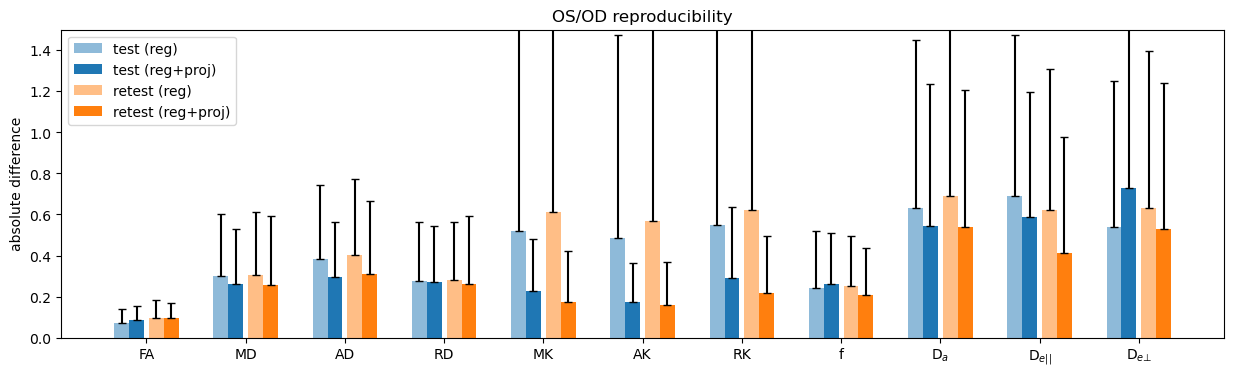

In [157]:
plt.figure(figsize=(15,4))

negative_bars = np.zeros(len(micro_param_names))

plt.bar(
    x=2*np.arange(len(micro_param_names))-0.5, 
    height=errors[:,DIFF_LEFT_RIGHT_TEST,DIFF_REG_AVG], 
    yerr=np.vstack((negative_bars, errors[:,DIFF_LEFT_RIGHT_TEST,DIFF_REG_STD])),
    width=0.3, capsize=3,
    color='C0', alpha = 0.5
)
plt.bar(
    x=2*np.arange(len(micro_param_names))-0.2, 
    height=errors[:,DIFF_LEFT_RIGHT_TEST,DIFF_REG_PROJ_AVG], 
    yerr=np.vstack((negative_bars, errors[:,DIFF_LEFT_RIGHT_TEST,DIFF_REG_PROJ_STD])),
    width=0.3, capsize=3,
    color='C0', alpha = 1.0
)
plt.bar(
    x=2*np.arange(len(micro_param_names))+0.2, 
    height=errors[:,DIFF_LEFT_RIGHT_RETEST,DIFF_REG_AVG], 
    yerr=np.vstack((negative_bars, errors[:,DIFF_LEFT_RIGHT_RETEST,DIFF_REG_STD])),
    width=0.3, capsize=3,
    color='C1', alpha = 0.5
)
plt.bar(
    x=2*np.arange(len(micro_param_names))+0.5, 
    height=errors[:,DIFF_LEFT_RIGHT_RETEST,DIFF_REG_PROJ_AVG], 
    yerr=np.vstack((negative_bars, errors[:,DIFF_LEFT_RIGHT_RETEST,DIFF_REG_PROJ_STD])),
    width=0.3, capsize=3,
    color='C1', alpha = 1.0
)

plt.xticks(
    2*np.arange(len(micro_param_names)), 
    [micro_param_labels[micro_param_name] for micro_param_name in micro_param_names]
)

plt.title('OS/OD reproducibility')
plt.legend(
    ['test (reg)', 'test (reg+proj)', 'retest (reg)', 'retest (reg+proj)'],
    loc='upper left'
)
plt.ylabel('absolute difference')
plt.ylim([0,1.5])

# plt.yscale('log')

pass


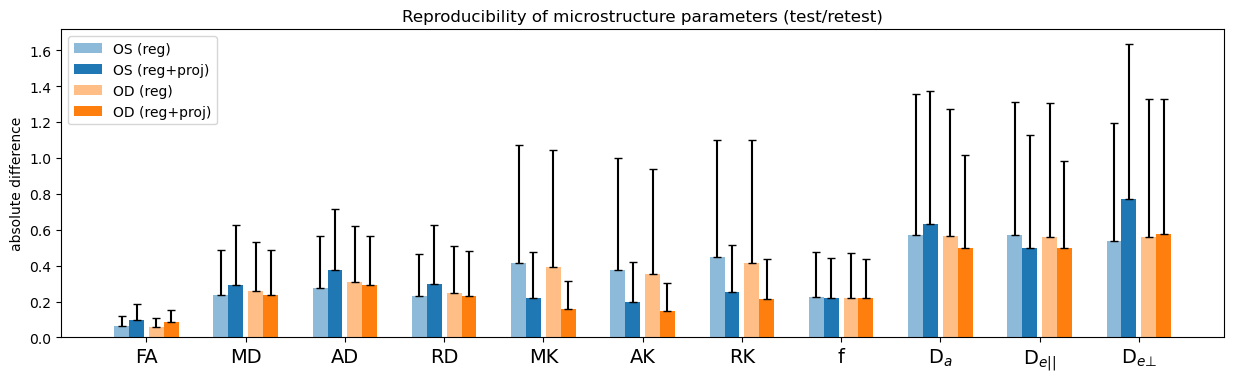

In [158]:
plt.figure(figsize=(15,4))

negative_bars = np.zeros(len(micro_param_names))

plt.bar(
    x=2*np.arange(len(micro_param_names))-0.5, 
    height=errors[:,DIFF_TEST_RETEST_LEFT,DIFF_REG_AVG], 
    yerr=np.vstack((negative_bars, errors[:,DIFF_TEST_RETEST_LEFT,DIFF_REG_STD])),
    width=0.3, capsize=3,
    color='C0', alpha = 0.5
)
plt.bar(
    x=2*np.arange(len(micro_param_names))-0.2, 
    height=errors[:,DIFF_TEST_RETEST_LEFT,DIFF_REG_PROJ_AVG], 
    yerr=np.vstack((negative_bars, errors[:,DIFF_TEST_RETEST_LEFT,DIFF_REG_PROJ_STD])),
    width=0.3, capsize=3,
    color='C0', alpha = 1.0
)
plt.bar(
    x=2*np.arange(len(micro_param_names))+0.2, 
    height=errors[:,DIFF_TEST_RETEST_RIGHT,DIFF_REG_AVG], 
    yerr=np.vstack((negative_bars, errors[:,DIFF_TEST_RETEST_RIGHT,DIFF_REG_STD])),
    width=0.3, capsize=3,
    color='C1', alpha = 0.5
)
plt.bar(
    x=2*np.arange(len(micro_param_names))+0.5, 
    height=errors[:,DIFF_TEST_RETEST_RIGHT,DIFF_REG_PROJ_AVG], 
    yerr=np.vstack((negative_bars, errors[:,DIFF_TEST_RETEST_RIGHT,DIFF_REG_PROJ_STD])),
    width=0.3, capsize=3,
    color='C1', alpha = 1.0
)

plt.xticks(
    2*np.arange(len(micro_param_names)), 
    [micro_param_labels[micro_param_name] for micro_param_name in micro_param_names], 
    fontsize=14
)

plt.title('Reproducibility of microstructure parameters (test/retest)')
plt.legend(
    ['OS (reg)', 'OS (reg+proj)', 'OD (reg)', 'OD (reg+proj)'],
    loc='upper left'
)
plt.ylabel('absolute difference')
# plt.ylim([0,1.0])

# plt.yscale('log')

pass

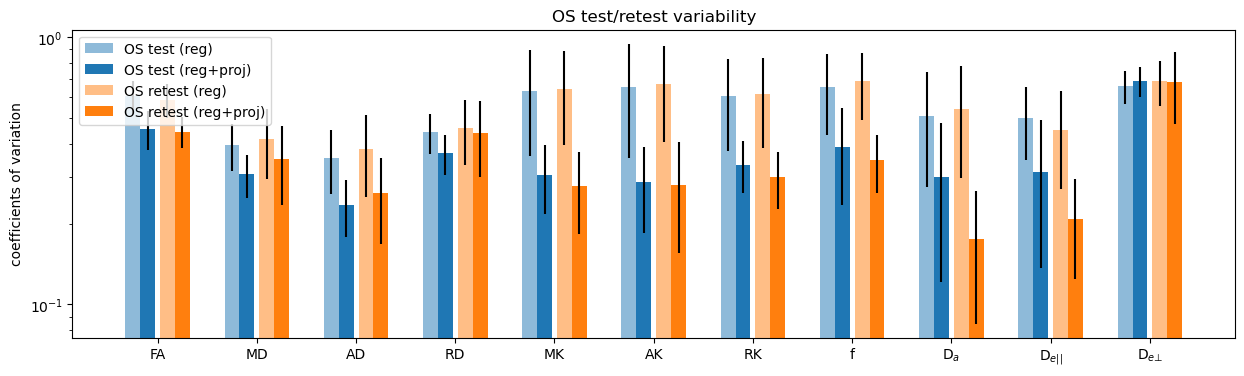

In [159]:
plt.figure(figsize=(15,4))

plt.bar(
    x=2*np.arange(len(micro_param_names))-0.5, 
    height=covs[:,COV_REG_AVG,COV_LEFT_TEST], 
    yerr=covs[:,COV_REG_STD,COV_LEFT_TEST], 
    width=0.3,
    color='C0', alpha = 0.5
)
plt.bar(
    x=2*np.arange(len(micro_param_names))-0.2, 
    height=covs[:,COV_REG_PROJ_AVG,COV_LEFT_TEST], 
    yerr=covs[:,COV_REG_PROJ_STD,COV_LEFT_TEST], 
    width=0.3,
    color='C0', alpha = 1.0
)
plt.bar(
    x=2*np.arange(len(micro_param_names))+0.2, 
    height=covs[:,COV_REG_AVG,COV_LEFT_RETEST], 
    yerr=covs[:,COV_REG_STD,COV_LEFT_RETEST], 
    width=0.3,
    color='C1', alpha = 0.5
)
plt.bar(
    x=2*np.arange(len(micro_param_names))+0.5, 
    height=covs[:,COV_REG_PROJ_AVG,COV_LEFT_RETEST], 
    yerr=covs[:,COV_REG_PROJ_STD,COV_LEFT_RETEST], 
    width=0.3,
    color='C1', alpha = 1.0
)

plt.xticks(
    2*np.arange(len(micro_param_names)), 
    [micro_param_labels[micro_param_name] for micro_param_name in micro_param_names]
)

plt.title('OS test/retest variability')
plt.legend(
    ['OS test (reg)', 'OS test (reg+proj)', 'OS retest (reg)', 'OS retest (reg+proj)'],
    loc='upper left'
)
plt.ylabel('coefficients of variation')
# plt.ylim([0,1.0])

plt.yscale('log')

pass



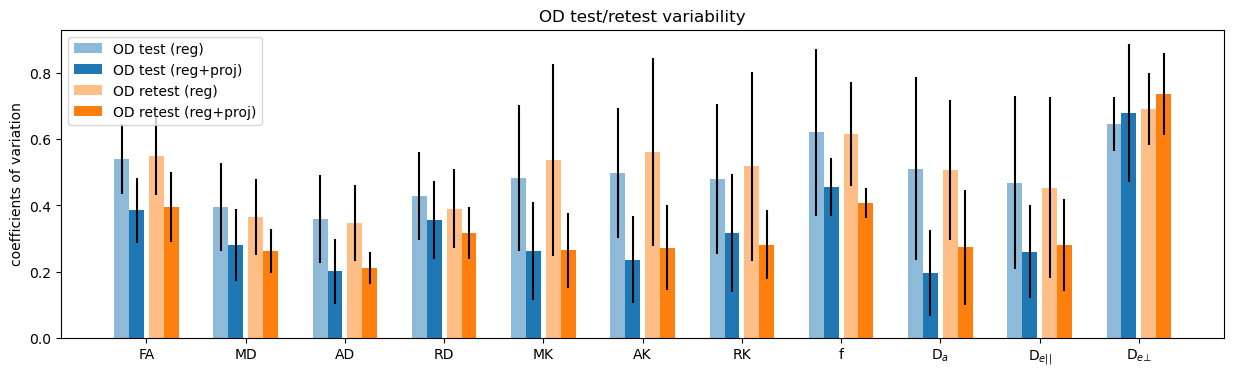

In [160]:
plt.figure(figsize=(15,4))

plt.bar(
    x=2*np.arange(len(micro_param_names))-0.5, 
    height=covs[:,COV_REG_AVG,COV_RIGHT_TEST], 
    yerr=covs[:,COV_REG_STD,COV_RIGHT_TEST], 
    width=0.3,
    color='C0', alpha = 0.5
)
plt.bar(
    x=2*np.arange(len(micro_param_names))-0.2, 
    height=covs[:,COV_REG_PROJ_AVG,COV_RIGHT_TEST], 
    yerr=covs[:,COV_REG_PROJ_STD,COV_RIGHT_TEST], 
    width=0.3,
    color='C0', alpha = 1.0
)
plt.bar(
    x=2*np.arange(len(micro_param_names))+0.2, 
    height=covs[:,COV_REG_AVG,COV_RIGHT_RETEST], 
    yerr=covs[:,COV_REG_STD,COV_RIGHT_RETEST], 
    width=0.3,
    color='C1', alpha = 0.5
)
plt.bar(
    x=2*np.arange(len(micro_param_names))+0.5, 
    height=covs[:,COV_REG_PROJ_AVG,COV_RIGHT_RETEST], 
    yerr=covs[:,COV_REG_PROJ_STD,COV_RIGHT_RETEST], 
    width=0.3,
    color='C1', alpha = 1.0
)

plt.xticks(
    2*np.arange(len(micro_param_names)), 
    [micro_param_labels[micro_param_name] for micro_param_name in micro_param_names]
)

plt.title('OD test/retest variability')
plt.legend(
    ['OD test (reg)', 'OD test (reg+proj)', 'OD retest (reg)', 'OD retest (reg+proj)'],
    loc='upper left'
)
plt.ylabel('coefficients of variation')
# plt.ylim([0,1.0])

# plt.yscale('log')

pass



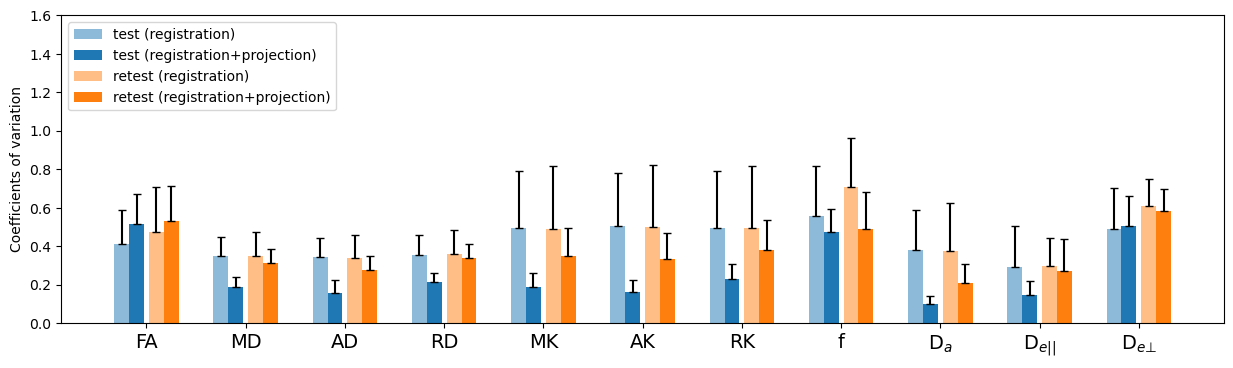

In [161]:
plt.figure(figsize=(15,4))
negative_bars = np.zeros(len(micro_param_names))

plt.bar(
    x=2*np.arange(len(micro_param_names))-0.5, 
    height=merged_covs[:,COV_REG_AVG,DIFF_LEFT_RIGHT_TEST], 
    yerr=np.vstack((negative_bars, merged_covs[:,COV_REG_STD,DIFF_LEFT_RIGHT_TEST])), 
    width=0.3, capsize=3,
    color='C0', alpha = 0.5
)
plt.bar(
    x=2*np.arange(len(micro_param_names))-0.2, 
    height=merged_covs[:,COV_REG_PROJ_AVG,DIFF_LEFT_RIGHT_TEST], 
    yerr=np.vstack((negative_bars, merged_covs[:,COV_REG_PROJ_STD,DIFF_LEFT_RIGHT_TEST])), 
    width=0.3, capsize=3,
    color='C0', alpha = 1.0
)
plt.bar(
    x=2*np.arange(len(micro_param_names))+0.2, 
    height=merged_covs[:,COV_REG_AVG,DIFF_LEFT_RIGHT_RETEST], 
    yerr=np.vstack((negative_bars, merged_covs[:,COV_REG_STD,DIFF_LEFT_RIGHT_RETEST])), 
    width=0.3, capsize=3,
    color='C1', alpha = 0.5
)
plt.bar(
    x=2*np.arange(len(micro_param_names))+0.5, 
    height=merged_covs[:,COV_REG_PROJ_AVG,DIFF_LEFT_RIGHT_RETEST], 
    yerr=np.vstack((negative_bars, merged_covs[:,COV_REG_PROJ_STD,DIFF_LEFT_RIGHT_RETEST])), 
    width=0.3, capsize=3,
    color='C1', alpha = 1.0
)

plt.xticks(
    2*np.arange(len(micro_param_names)), 
    [micro_param_labels[micro_param_name] for micro_param_name in micro_param_names],
    fontsize=14
)

# plt.title('Variability of microstructure parameters')
plt.legend(
    ['test (registration)', 'test (registration+projection)', 'retest (registration)', 'retest (registration+projection)'],
    loc='upper left', ncols=1
)
plt.ylabel('Coefficients of variation')
plt.ylim([0,1.6])

# plt.yscale('log')

plt.savefig("%s/cov_seg%d.png" % (plots_dir, CURRENT_SEGMENT), bbox_inches='tight')



In [162]:
1 - np.median(
    np.hstack((
        merged_covs[:,COV_REG_PROJ_AVG,DIFF_LEFT_RIGHT_TEST], merged_covs[:,COV_REG_PROJ_AVG,DIFF_LEFT_RIGHT_RETEST]
    ))
    / 
    np.hstack((
        merged_covs[:,COV_REG_AVG,DIFF_LEFT_RIGHT_TEST], merged_covs[:,COV_REG_AVG,DIFF_LEFT_RIGHT_RETEST]
    ))
)

0.29781266190029165